In [1]:
import os
import cv2
from tqdm import tqdm

# Pytorch
import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

Data/images_original/blues


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 511.00it/s]


Data/images_original/classical


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 616.80it/s]


Data/images_original/country


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.00it/s]


Data/images_original/disco


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 507.44it/s]


Data/images_original/hiphop


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 550.14it/s]


Data/images_original/jazz


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 578.80it/s]


Data/images_original/metal


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 467.98it/s]


Data/images_original/pop


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 530.47it/s]


Data/images_original/reggae


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 571.23it/s]


Data/images_original/rock


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 489.87it/s]
C:\Users\Jenai\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


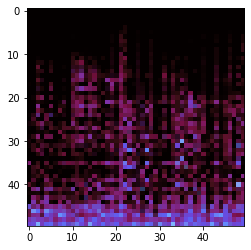

In [2]:
# spectrogram image of audio files for each genre
image_size = 50
class MusicGenre():
    BLUES = "Data/images_original/blues"
    CLASSICAL = "Data/images_original/classical"
    COUNTRY = "Data/images_original/country"
    DISCO = "Data/images_original/disco"
    HIPHOP = "Data/images_original/hiphop"
    JAZZ = "Data/images_original/jazz"
    METAL = "Data/images_original/metal"
    POP = "Data/images_original/pop"
    REGGAE = "Data/images_original/reggae"
    ROCK = "Data/images_original/rock"
    LABELS = {BLUES: 0, CLASSICAL: 1, COUNTRY: 2, DISCO: 3, HIPHOP: 4, JAZZ: 5, METAL: 6, POP: 7, REGGAE: 8, ROCK: 9}
    training_data = []
    
    
    # preparing the training data
    def build_training(self):
        for label in self.LABELS:
            print(label)
            for file in tqdm(os.listdir(label)):
                path = os.path.join(label, file)
                image = cv2.imread(path)
                image = cv2.resize(image, (image_size, image_size))
                self.training_data.append([np.array(image), np.eye(10)[self.LABELS[label]]])
                
        # shuffling the training data
        np.random.shuffle(self.training_data)
        np.save("train_dt.npy", self.training_data)
        plt.imshow(self.training_data[1][0])
        plt.show()
 
musicgenre = MusicGenre()
musicgenre.build_training()
t_data = np.load("train_dt.npy", allow_pickle=True)

In [145]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 4 convolutional layers
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        
        # dense (linear) layers
        self.fc1 = nn.Linear(64, 512)
        self.fc2 = nn.Linear(512, 10) # 512 in, 10 out (10 classes)
        self.dropout = nn.Dropout(p=0.7)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv4(x)), kernel_size=2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
    
        return F.softmax(x, dim=1) # normalise output applied to multiclass to get target class probabilities

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
)


In [138]:
import torch.optim as optim

#loss: measure of how wrong the model is
#optimiser: adjust weights based on the loss
optimizer = optim.Adam(net.parameters(), lr=0.001)
citeration = nn.MSELoss()

In [139]:
# making the training/testing split
X = torch.Tensor([i[0] for i in t_data]).view(-1,3,  image_size, image_size)
y = torch.Tensor([i[1] for i in t_data])

validation_size = int(len(X)*0.1)
print("Validation size: ", validation_size)

train_X = X[:-validation_size]
train_y = y[:-validation_size]

test_X = X[-validation_size:]
test_y = y[-validation_size:]

Validation size:  99


In [140]:
def eval_pairs(out, y, pairs):
    for i, j in zip(out, y):
        pairs = pairs + [torch.argmax(i) == torch.argmax(j)]
    return pairs

def forward_propagation(X, y, train=False):
    pairs = []
    if train:
        optimizer.zero_grad() # zero the parameter gradients
    out = net(X)
    pairs = eval_pairs(out, y, pairs)
    accuracy = pairs.count(True)/len(pairs)
    loss = citeration(out, y) # get the loss
    if train:
        loss.backward() # calculate gradients
        optimizer.step() # update weights
    return accuracy, loss
    
def test_model(size=32):
    X, y = test_X[:size], test_y[:size]
    #with torch.no_grad():
    validation_acc, validation_loss = forward_propagation(X.view(-1, 3, 50, 50), y)
    return validation_acc, validation_loss

validation_acc, validation_loss = test_model()
print(validation_acc, validation_loss)
#forward_pass(X, y)

0.03125 tensor(0.1429, grad_fn=<MseLossBackward0>)


In [144]:
import time

m_name = "Model-" + str(int(time.time())) # makes the model name dynamic by using current time

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)


def write_values(acc, loss, v_acc, v_loss):
    return m_name, str(round(time.time(), 3)), str(round(float(acc), 2)), str(round(float(loss), 4)), str(round(float(v_acc), 2)), str(round(float(v_loss), 4))

def train_model():
    batch = 32
    start = True
    with open("m.csv", "a") as infile:
        for epoch in range(10):
            for i in tqdm(range(0, len(train_X), batch)):
                # get the inputs in batches
                batch_X = train_X[i: i+batch].view(-1, 3, image_size, image_size)
                batch_y = train_y[i: i+batch]
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                accuracy, loss = forward_propagation(batch_X, batch_y, train=True)
                if start:
                    infile.truncate(0)
                    start = False
                if i % 50 == 0:
                    validation_acc, validation_loss = test_model(size=100)
                    infile.write(','.join(write_values(accuracy, loss, validation_acc, validation_loss)))
                    infile.write("\n")
                                                                                                        
                                                                                                                                                      
train_model()

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 84.90it/s]


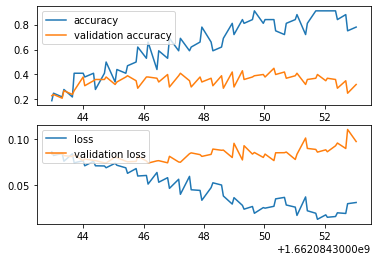

In [143]:
def create_acc_graph():
    data = pd.read_csv("m.csv")
    tstamp = data.iloc[:, 1].tolist()
    acc = data.iloc[:, 2].tolist()
    loss = data.iloc[:, 3].tolist()
    v_acc = data.iloc[:, 4].tolist()
    v_loss = data.iloc[:, 5].tolist()
    
    fig = plt.figure()
    axis1 = plt.subplot2grid((2, 1), (0, 0))
    axis2 = plt.subplot2grid((2, 1), (1, 0), sharex=axis1)
    axis1.plot(tstamp, acc, label="accuracy")
    axis1.plot(tstamp, v_acc, label="validation accuracy")
    axis1.legend(loc=2)
    axis2.plot(tstamp, loss, label="loss")
    axis2.plot(tstamp, v_loss, label="validation loss")
    axis2.legend(loc=2)
    plt.show()
    
    
create_acc_graph()